In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import geopandas as gpd
from src.organized_datasets_creation.utils import resolve_nominatim_city_name
from src.graph_layering.create_dataframes import create_osmnx_dataframes
from src.organized_datasets_creation.utils import convert_nominatim_name_to_filename
from src.graph_layering.graph_layer_creator import GraphLayerController
import pandas as pd
from typing import cast
import os
from src.graph_layering.graph_layer_creator import SourceType
import warnings
from src.graph_layering.hetero_data import create_hetero_data

from sklearn.metrics import roc_auc_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm
import torch
import torch.optim as optim
import torch.nn.functional as F
from torch_geometric.loader import DataLoader
import numpy as np

from src.baseline_models.HeteroGNN import HeteroGNN


In [3]:
GRAPH_LOCATION = "/home/staszek/mgr/gradient/gradient/data/wro/wro-map.osm"
ACCIDENTS_LOCATION = "/home/staszek/mgr/gradient/gradient/data/wypadki-pl/accidents.csv"
ORGANIZED_DATASETS_LOCATION = (
    "/home/staszek/mgr/gradient/gradient/data/organized-datasets"
)

In [4]:
accidents = gpd.read_file(ACCIDENTS_LOCATION)

In [5]:
cities = [
    'Wrocław, Poland',
    'Warsaw, Poland',
    'Szczecin, Poland',
    'Poznań, Poland',
    'Kraków, Poland',
]

In [6]:
def create_gdfs(city_name: str, h3_resolution: int = 9, year:int = 2017):
    osmnx_nodes, osmnx_edges = create_osmnx_dataframes(ACCIDENTS_LOCATION, city_name)
    hexes: gpd.GeoDataFrame = gpd.read_parquet(
        os.path.join(
            ORGANIZED_DATASETS_LOCATION, f"{convert_nominatim_name_to_filename(resolve_nominatim_city_name(city_name))}/{year}/h{h3_resolution}/count-embedder/dataset.parquet"
        )
    )
    hexes = (
        hexes.rename(columns={"region_id": "h3_id"})
        .rename_axis("region_id", axis=0)
        .drop(columns="accidents_count")
    )  # we will be using different aggregation type than the one in the dataset
    
    return dict(osmnx_nodes=osmnx_nodes, osmnx_edges=osmnx_edges, hexes=hexes)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    gdfs_dict = {city_name: create_gdfs(city_name) for city_name in tqdm(cities)}

100%|██████████| 5/5 [03:15<00:00, 39.01s/it]


# Usuwanie kolumn, które nie są wspólne dla wszystkich miast

In [7]:
def get_presence_df(gdfs_dict, tested_df_name):
    presence_df = pd.DataFrame(list(map(lambda v: (v[0], v[1][tested_df_name].columns.to_list()), list(gdfs_dict.items()))), columns=['city_name', 'col']).explode('col')
    presence_df = pd.get_dummies(presence_df, columns=['col'], prefix='', prefix_sep='').groupby('city_name').sum()
    return presence_df

def filter_presence_df(df):
    return df.loc[:, df.sum(axis=0) == len(cities)]

def get_common_columns(gdfs_dict, tested_df_name):
    df_columns_presence = get_presence_df(gdfs_dict, tested_df_name)
    df_common_columns = filter_presence_df(df_columns_presence)
    return df_common_columns

In [8]:
df_osmnx_node_common_columns = get_common_columns(gdfs_dict, 'osmnx_nodes')
df_osmnx_node_common_columns

,accidents_count,crossing,geometry,mini_roundabout,motorway_junction,osmid,street_count,traffic_signals,turning_circle,x,y
city_name,,,,,,,,,,,
"Kraków, Poland",1,1,1,1,1,1,1,1,1,1,1
"Poznań, Poland",1,1,1,1,1,1,1,1,1,1,1
"Szczecin, Poland",1,1,1,1,1,1,1,1,1,1,1
"Warsaw, Poland",1,1,1,1,1,1,1,1,1,1,1
"Wrocław, Poland",1,1,1,1,1,1,1,1,1,1,1


In [9]:
df_osmnx_edge_common_columns = get_common_columns(gdfs_dict, 'osmnx_edges')
df_osmnx_edge_common_columns

,access_0,access_destination,access_no,access_permissive,access_yes,bridge_0,bridge_viaduct,bridge_yes,geometry,highway_living_street,...,length,maxspeed,oneway,reversed,tunnel_0,tunnel_building_passage,tunnel_yes,u,v,width
city_name,,,,,,,,,,,,,,,,,,,,,
"Kraków, Poland",1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
"Poznań, Poland",1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
"Szczecin, Poland",1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
"Warsaw, Poland",1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
"Wrocław, Poland",1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1


In [10]:
df_hexes_common_columns = get_common_columns(gdfs_dict, 'hexes')
df_hexes_common_columns

,aeroway_aerodrome,aeroway_helipad,aeroway_runway,amenity_animal_shelter,amenity_arts_centre,amenity_atm,amenity_bank,amenity_bar,amenity_bbq,amenity_bench,...,water_pond,water_reservoir,water_river,water_wastewater,waterway_canal,waterway_ditch,waterway_drain,waterway_river,waterway_stream,waterway_weir
city_name,,,,,,,,,,,,,,,,,,,,,
"Kraków, Poland",1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
"Poznań, Poland",1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
"Szczecin, Poland",1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
"Warsaw, Poland",1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
"Wrocław, Poland",1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1


In [11]:
for gdf_for_city in gdfs_dict.values():
    osmnx_nodes = gdf_for_city['osmnx_nodes']
    osmnx_edges = gdf_for_city['osmnx_edges']
    hexes = gdf_for_city['hexes']
    
    osmnx_nodes.drop(columns=osmnx_nodes.columns.difference(df_osmnx_node_common_columns.columns), inplace=True)
    osmnx_edges.drop(columns=osmnx_edges.columns.difference(df_osmnx_edge_common_columns.columns), inplace=True)
    hexes.drop(columns=hexes.columns.difference(df_hexes_common_columns.columns), inplace=True)

    gdf_for_city['osmnx_nodes'] = osmnx_nodes.reindex(columns=df_osmnx_node_common_columns.columns)
    gdf_for_city['osmnx_edges'] = osmnx_edges.reindex(columns=df_osmnx_edge_common_columns.columns)
    gdf_for_city['hexes'] = hexes.reindex(columns=df_hexes_common_columns.columns)

    gdf_for_city['controller'] = GraphLayerController(gdf_for_city['hexes'], gdf_for_city['osmnx_nodes'], gdf_for_city['osmnx_edges'])

/home/staszek/mgr/gradient/gradient/src/graph_layering/graph_layer_creator.py:410: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  self.hexes_gdf.centroid, columns=["centroid_geometry"]
/home/staszek/mgr/gradient/gradient/src/graph_layering/graph_layer_creator.py:410: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  self.hexes_gdf.centroid, columns=["centroid_geometry"]
/home/staszek/mgr/gradient/gradient/src/graph_layering/graph_layer_creator.py:410: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  self.hexes_gdf.centroid, columns=["centroid_geometry"]
/home/staszek/mgr/gradien

In [12]:
def patch_hexes_with_y(
        osmnx_nodes: gpd.GeoDataFrame, hexes: gpd.GeoDataFrame, controller: GraphLayerController
):
    virtual_edges = controller.get_virtual_edges_to_hexes(SourceType.OSMNX_NODES)
    hexes_with_y = cast(gpd.GeoDataFrame, hexes.merge(
        virtual_edges.merge(osmnx_nodes, left_on="source_id", right_index=True)[
            ["region_id", "accidents_count"]
        ]
        .groupby("region_id")
        .sum(),
        left_index=True,
        right_index=True,
        how="left",
    ).fillna(
        0
    ))
    hexes_with_y["accident_occured"] = (hexes_with_y["accidents_count"] > 0).astype(int)
    hexes_with_y.drop(columns="accidents_count", inplace=True)
    controller.hexes_gdf = hexes_with_y
    controller._hexes_centroids_gdf = controller._create_hexes_centroids_gdf()

In [13]:
for gdfs in gdfs_dict.values():
    patch_hexes_with_y(gdfs['osmnx_nodes'], gdfs['hexes'], gdfs['controller'])

/home/staszek/mgr/gradient/gradient/src/graph_layering/graph_layer_creator.py:410: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  self.hexes_gdf.centroid, columns=["centroid_geometry"]
/home/staszek/mgr/gradient/gradient/src/graph_layering/graph_layer_creator.py:410: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  self.hexes_gdf.centroid, columns=["centroid_geometry"]
/home/staszek/mgr/gradient/gradient/src/graph_layering/graph_layer_creator.py:410: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  self.hexes_gdf.centroid, columns=["centroid_geometry"]
/home/staszek/mgr/gradien

In [14]:
def create_torch_geometric_hetero_data(osmnx_nodes, osmnx_edges, hexes, controller: GraphLayerController):
    edges_attr_columns = osmnx_edges.columns[
        ~osmnx_edges.columns.isin(["u", "v", "key", "geometry"])
    ]
    nodes_attr_columns = osmnx_nodes.columns[
        ~osmnx_nodes.columns.isin(["geometry", "x", "y", "osmid", "accidents_count"])
    ]
    hexes_attr_columns = hexes.columns[~hexes.columns.isin(["geometry", "h3_id"])]
    
    data = create_hetero_data(
        controller,
        hexes_attrs_columns_names=hexes_attr_columns,
        osmnx_edge_attrs_columns_names=edges_attr_columns,
        osmnx_node_attrs_columns_names=nodes_attr_columns,
        virtual_edge_attrs_columns_names=[],
        hexes_y_columns_names=["accident_occured"],
    )
    return data

data_dict = {city_name: create_torch_geometric_hetero_data(**gdfs) for city_name, gdfs in gdfs_dict.items()}

HeteroGNN(
  (convs): ModuleList(
    (0): HeteroConv(num_relations=3)
  )
  (lin_layers): Sequential(
    (0) - HeteroDictLinear({'hex': 10, 'osmnx_node': 10}, 8, bias=True): dictionary -> dictionary
    (1) - HeteroDictLinear({'hex': 8, 'osmnx_node': 8}, 2, bias=True): dictionary -> dictionary
  )
  (batch_norm): HeteroDictBatchNorm(
    (batch_norm): ModuleDict(
      (hex): BatchNorm(10)
      (osmnx_node): BatchNorm(10)
    )
  )
)


100%|██████████| 1000/1000 [00:13<00:00, 76.24it/s]


ROC AUC Score: 0.7984378620529852


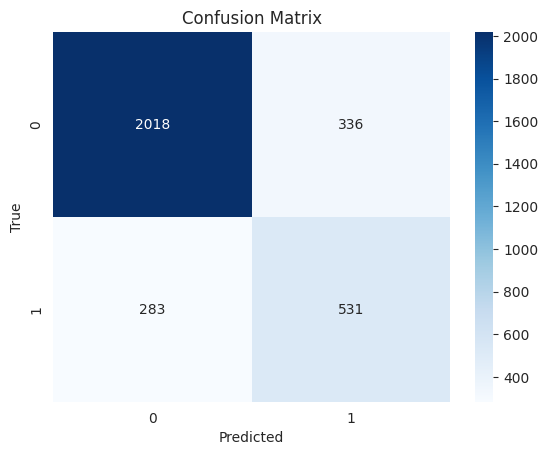

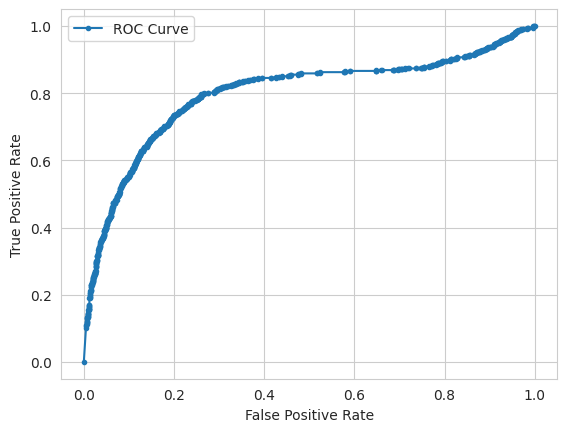

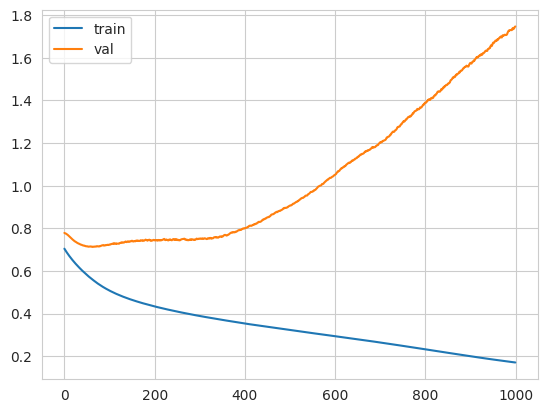

In [27]:
from sklearn.metrics import roc_curve
from torch_geometric.data import HeteroData

hetero_gnn = HeteroGNN(
    hidden_channels=10,
    out_channels=2,
    num_conv_layers=1,
    lin_layer_sizes=[8],
    hetero_data=data_dict['Wrocław, Poland'],
    add_batch_norm=True,
)
print(hetero_gnn)

def get_normalization_params(hetero_data_objs: 'list[HeteroData]'):
    hexes_X = torch.vstack([data['hex'].x for data in hetero_data_objs])
    osmnx_nodes_X = torch.vstack([data['osmnx_node'].x for data in hetero_data_objs])
    layer_1_edges_X = torch.vstack([data['osmnx_node', 'connected_to', 'osmnx_node'].edge_attr for data in hetero_data_objs])

    hexes_std, hexes_mean = torch.std_mean(hexes_X, dim=0)
    osmnx_nodes_std, osmnx_nodes_mean = torch.std_mean(osmnx_nodes_X, dim=0)
    layer_1_edges_std, layer_1_edges_mean = torch.std_mean(layer_1_edges_X, dim=0)

    return dict(hexes_std=hexes_std, hexes_mean=hexes_mean, osmnx_nodes_std=osmnx_nodes_std, osmnx_nodes_mean=osmnx_nodes_mean, layer_1_edges_std=layer_1_edges_std, layer_1_edges_mean=layer_1_edges_mean)

def normalize_data(hetero_data_objs: 'list[HeteroData]', normalization_params):
    hexes_std = normalization_params['hexes_std']
    hexes_mean = normalization_params['hexes_mean']
    osmnx_nodes_std = normalization_params['osmnx_nodes_std']
    osmnx_nodes_mean = normalization_params['osmnx_nodes_mean']
    layer_1_edges_std = normalization_params['layer_1_edges_std']
    layer_1_edges_mean = normalization_params['layer_1_edges_mean']
    
    for data in hetero_data_objs:
        data['hex'].x = (data['hex'].x - hexes_mean) / hexes_std
        data['osmnx_node'].x = (data['osmnx_node'].x - osmnx_nodes_mean) / osmnx_nodes_std
        data['osmnx_node', 'connected_to', 'osmnx_node'].edge_attr = (data['osmnx_node', 'connected_to', 'osmnx_node'].edge_attr - layer_1_edges_mean) / layer_1_edges_std

def train(model, val_city_name, test_city_name, epochs=1000):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    val_data = [data_dict[val_city_name].to(device)]
    train_data = [v.to(device) for k, v in data_dict.items() if k != val_city_name and k != test_city_name]
    test_data = data_dict[test_city_name].to(device)
    
    parameters_dict = get_normalization_params(train_data)
    normalize_data(train_data, normalization_params=parameters_dict)
    normalize_data(val_data, normalization_params=parameters_dict)
    normalize_data([test_data], normalization_params=parameters_dict)

    model.to(device)
    train_loader = DataLoader(train_data, batch_size=1, shuffle=True)
    val_loader = DataLoader(val_data, batch_size=1, shuffle=False)
    
    with torch.no_grad():  # Initialize lazy modules.
        batch = next(iter(train_loader))
        _ = hetero_gnn(batch.x_dict, batch.edge_index_dict, batch.edge_attr_dict)
    
    optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5, )
    
    weights = torch.tensor([0.4, 0.6]).to(device)
    losses = []
    val_losses = []
    for _ in tqdm(range(epochs)):
        model.train()
        loss_epoch = []
        for batch in train_loader:
            optimizer.zero_grad()
            y_hat = model(batch.x_dict, batch.edge_index_dict, batch.edge_attr_dict)
            loss = F.cross_entropy(y_hat["hex"], batch["hex"].y, weight=weights)
            loss_epoch.append(loss.item())
            loss.backward()
            optimizer.step()
        losses.append(np.mean(loss_epoch))
        
        model.eval()
        with torch.no_grad():    
            val_loss_epoch = []
            for batch in val_loader:
                y_hat = model(batch.x_dict, batch.edge_index_dict, batch.edge_attr_dict)
                val_loss = F.cross_entropy(y_hat["hex"], batch["hex"].y, weight=weights)
                val_loss_epoch.append(val_loss.item())
            val_losses.append(np.mean(val_loss_epoch))

    model.eval()

    with torch.no_grad():
        y_hat = model(test_data.x_dict, test_data.edge_index_dict, test_data.edge_attr_dict)
        y_hat = torch.softmax(y_hat["hex"], dim=-1)
    
        auc = roc_auc_score(
            test_data["hex"].y.cpu().numpy(),
            y_hat[:, 1].cpu().numpy(),
            average="micro",
        )
        print(f"ROC AUC Score: {auc}")
        # Assuming you have the true labels in the variable 'true_labels' and the predicted labels in the variable 'predicted_labels'
        conf_matrix = confusion_matrix(
            test_data["hex"].y.cpu().numpy(), torch.argmax(y_hat, dim=1).cpu().numpy()
        )
    
        # Plot confusion matrix as heatmap
        sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
    
        # Set labels and title
        plt.xlabel("Predicted")
        plt.ylabel("True")
        plt.title("Confusion Matrix")
    
        # Show the plot
        plt.show()
    #     plot ROC curve for positive class
        fpr, tpr, _ = roc_curve(test_data["hex"].y.cpu().numpy(), y_hat[:, 1].cpu().numpy())
        
        plt.plot(fpr, tpr, marker='.', label='ROC Curve')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.legend()
        plt.show()
        
    return losses, val_losses
            

losses, val_losses = train(hetero_gnn, 'Warsaw, Poland', 'Wrocław, Poland', 1000)

plt.plot(losses, label='train')
plt.plot(val_losses, label='val')
plt.legend()
plt.show()
    